In [1]:
from openbabel import openbabel
from openbabel import pybel
import numpy as np
from rdkit.Chem import Mol
from tqdm import tqdm 

from rdkit import Chem
from rdkit.Chem import AllChem

In [2]:
from rdkit.Chem.rdmolfiles import MolFromPDBFile
from rdkit.Chem.rdchem import Mol
from rdkit.Chem import AllChem

import numpy as np
import rdkit.Chem as Chem
from rdkit.Chem import AddHs, AssignStereochemistry, HybridizationType, ChiralType, BondStereo, MolFromMol2File
from rdkit.Chem.AllChem import ComputeGasteigerCharges
import os
import sys
sys.path.append("../../")
from src.data.pocket_utils import get_atom_coordinates, find_pocket_atoms_RDKit
from src.data.utils import pdb_to_rdkit_mol, mol2_to_rdkit_mol, get_vdw_radius, add_charges_to_molecule, get_node_features, get_edge_features, extract_charges_from_mol2
from src.utils.constants import ES_THRESHOLD


In [3]:
complex_mol = mol2_to_rdkit_mol("../../test_data/pdb/1a0q/1a0q_complex_charged.mol2", sanitize = False) #/Users/tsachmackey/Documents/Summer 2024/Research /Batista project/AffinityNet/test_data/pdb/1a0q
ligand_mol = mol2_to_rdkit_mol("../../test_data/pdb/1a0q/1a0q_ligand.mol2", sanitize = False) #/Users/tsachmackey/Documents/Summer 2024/Research /Batista project/AffinityNet/test_data/pdb/1a0q
num_atoms_in_protein = len(complex_mol.GetAtoms()) - len(ligand_mol.GetAtoms())
charges = extract_charges_from_mol2("../../test_data/pdb/1a0q/1a0q_complex_charged.mol2")

mol = complex_mol
AssignStereochemistry(mol, force=True, cleanIt=True)
protein_or_ligand_ids = [-1 if atom.GetIdx() < num_atoms_in_protein else 1 for atom in mol.GetAtoms()]
pocket_atom_indices = find_pocket_atoms_RDKit(complex_mol, protein_or_ligand_ids, num_atoms_in_protein)

100%|██████████| 6349/6349 [00:00<00:00, 214928.46it/s]


In [4]:
mol = complex_mol
AssignStereochemistry(mol, force=True, cleanIt=True)
protein_or_ligand_ids = [-1 if atom.GetIdx() < num_atoms_in_protein else 1 for atom in mol.GetAtoms()]
pocket_atom_indices = find_pocket_atoms_RDKit(complex_mol, protein_or_ligand_ids, num_atoms_in_protein)

100%|██████████| 6349/6349 [00:00<00:00, 230915.49it/s]


In [5]:
def create_pocket_mol(original_mol, pocket_atom_indices):
    pocket_mol = Chem.RWMol()
    atom_mapping = {}

    # Add atoms with coordinates and charge information
    for idx in pocket_atom_indices:
        atom = original_mol.GetAtomWithIdx(idx)
        new_idx = pocket_mol.AddAtom(atom)
        atom_mapping[idx] = new_idx

    # Add bonds
    for bond in original_mol.GetBonds():
        start, end = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
        if start in pocket_atom_indices and end in pocket_atom_indices:
            pocket_mol.AddBond(atom_mapping[start], atom_mapping[end], bond.GetBondType())

    # Copy conformer (3D coordinates)
    conf = original_mol.GetConformer()
    new_conf = Chem.Conformer(len(pocket_atom_indices))
    for original_idx, new_idx in atom_mapping.items():
        pos = conf.GetAtomPosition(original_idx)
        new_conf.SetAtomPosition(new_idx, pos)
    pocket_mol.AddConformer(new_conf)

    # Copy charge information
    for original_idx, new_idx in atom_mapping.items():
        charge = original_mol.GetAtomWithIdx(original_idx).GetProp('_TriposPartialCharge')
        pocket_mol.GetAtomWithIdx(new_idx).SetProp('_TriposPartialCharge', charge)

    return pocket_mol

def save_mol_to_sdf(mol, filename):
    writer = Chem.SDWriter(filename)
    writer.write(mol)
    writer.close()
    
# Create a new mol object with only pocket atoms
pocket_mol = create_pocket_mol(complex_mol, pocket_atom_indices)

# Save the new mol to a file
output_filename = "../../test_data/pdb/1a0q/1a0q_complex_spheroid_pocket.sdf"
save_mol_to_sdf(pocket_mol, output_filename)

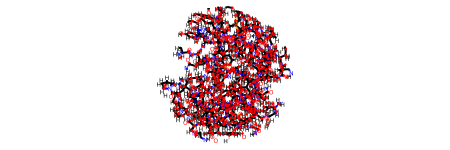

In [6]:
pocket_mol